In [5]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Load Dataset

Dataset Original Length n:  10358
Dataset Sampled Length n:  10358


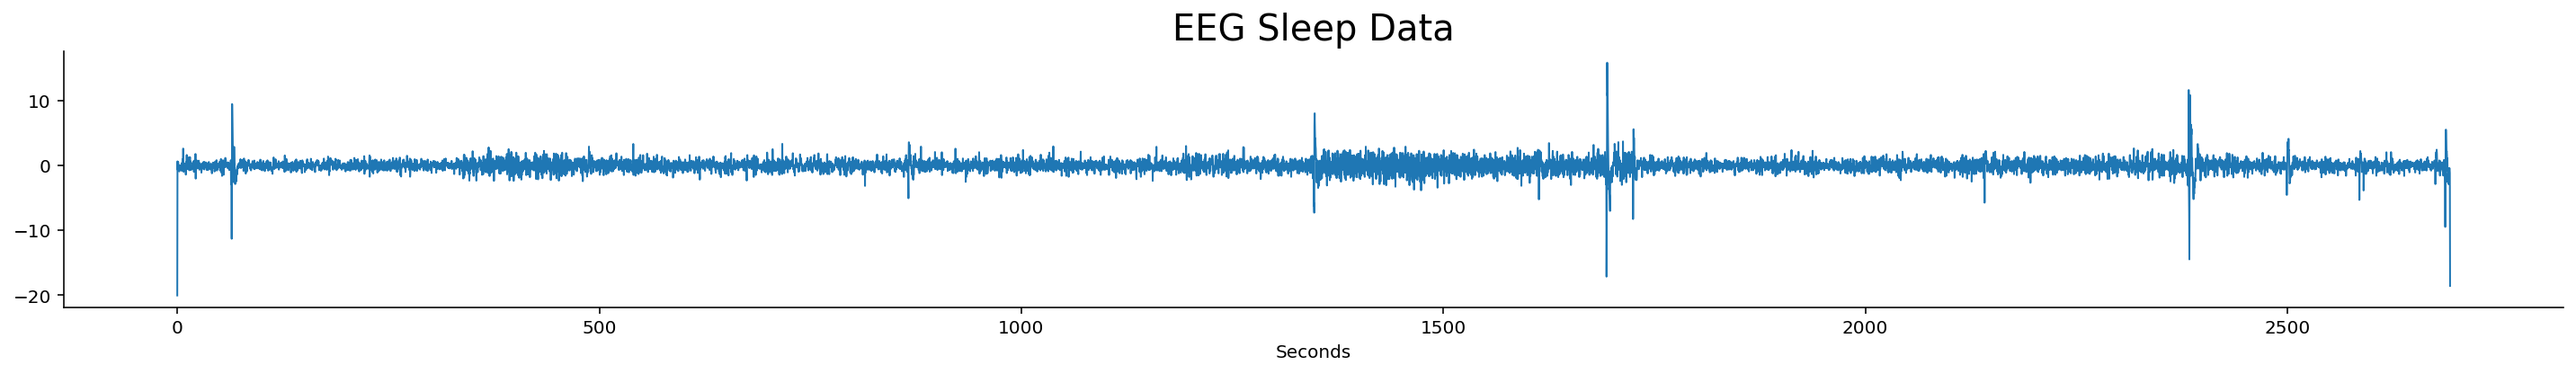

In [6]:
file = 'npo141.csv' # Dataset Length n:  269286
ds_name="EEG Sleep Data"
series = ml.read_dataset_with_index(file) 
data = series.values
#series = ml.as_series(data, np.arange(0, 269286, 26) / 100, 'Seconds')
plot_dataset(file, series, ds_name=ds_name)

# Parameters

In [7]:
df = pd.DataFrame() # TOP-1
df_comp = pd.DataFrame(columns=["Method", "Motif", "Extent", "k"]) # Complete Info

rerun_all_jars = True
motif_length = 115
ks=20
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset)

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/npo141.csv


# k-Motiflets

## First, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 18/18 [00:19<00:00,  1.06s/it]


Chosen window-size: 115
Identified Elbow Points [ 3 10 14 16]
Filtered Elbow Points [3, 16]


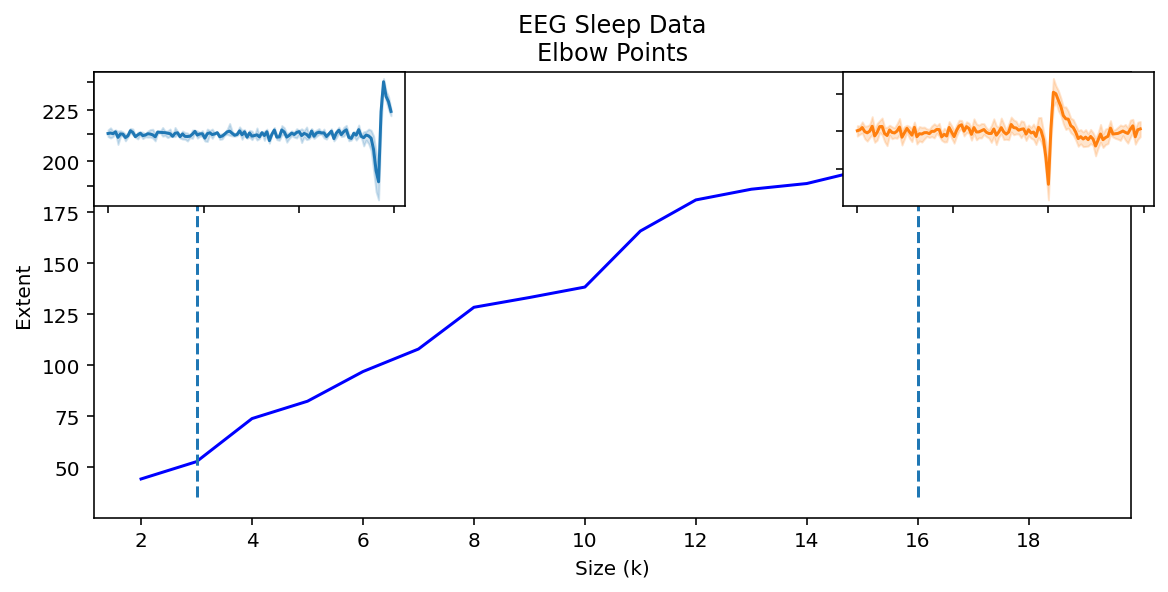

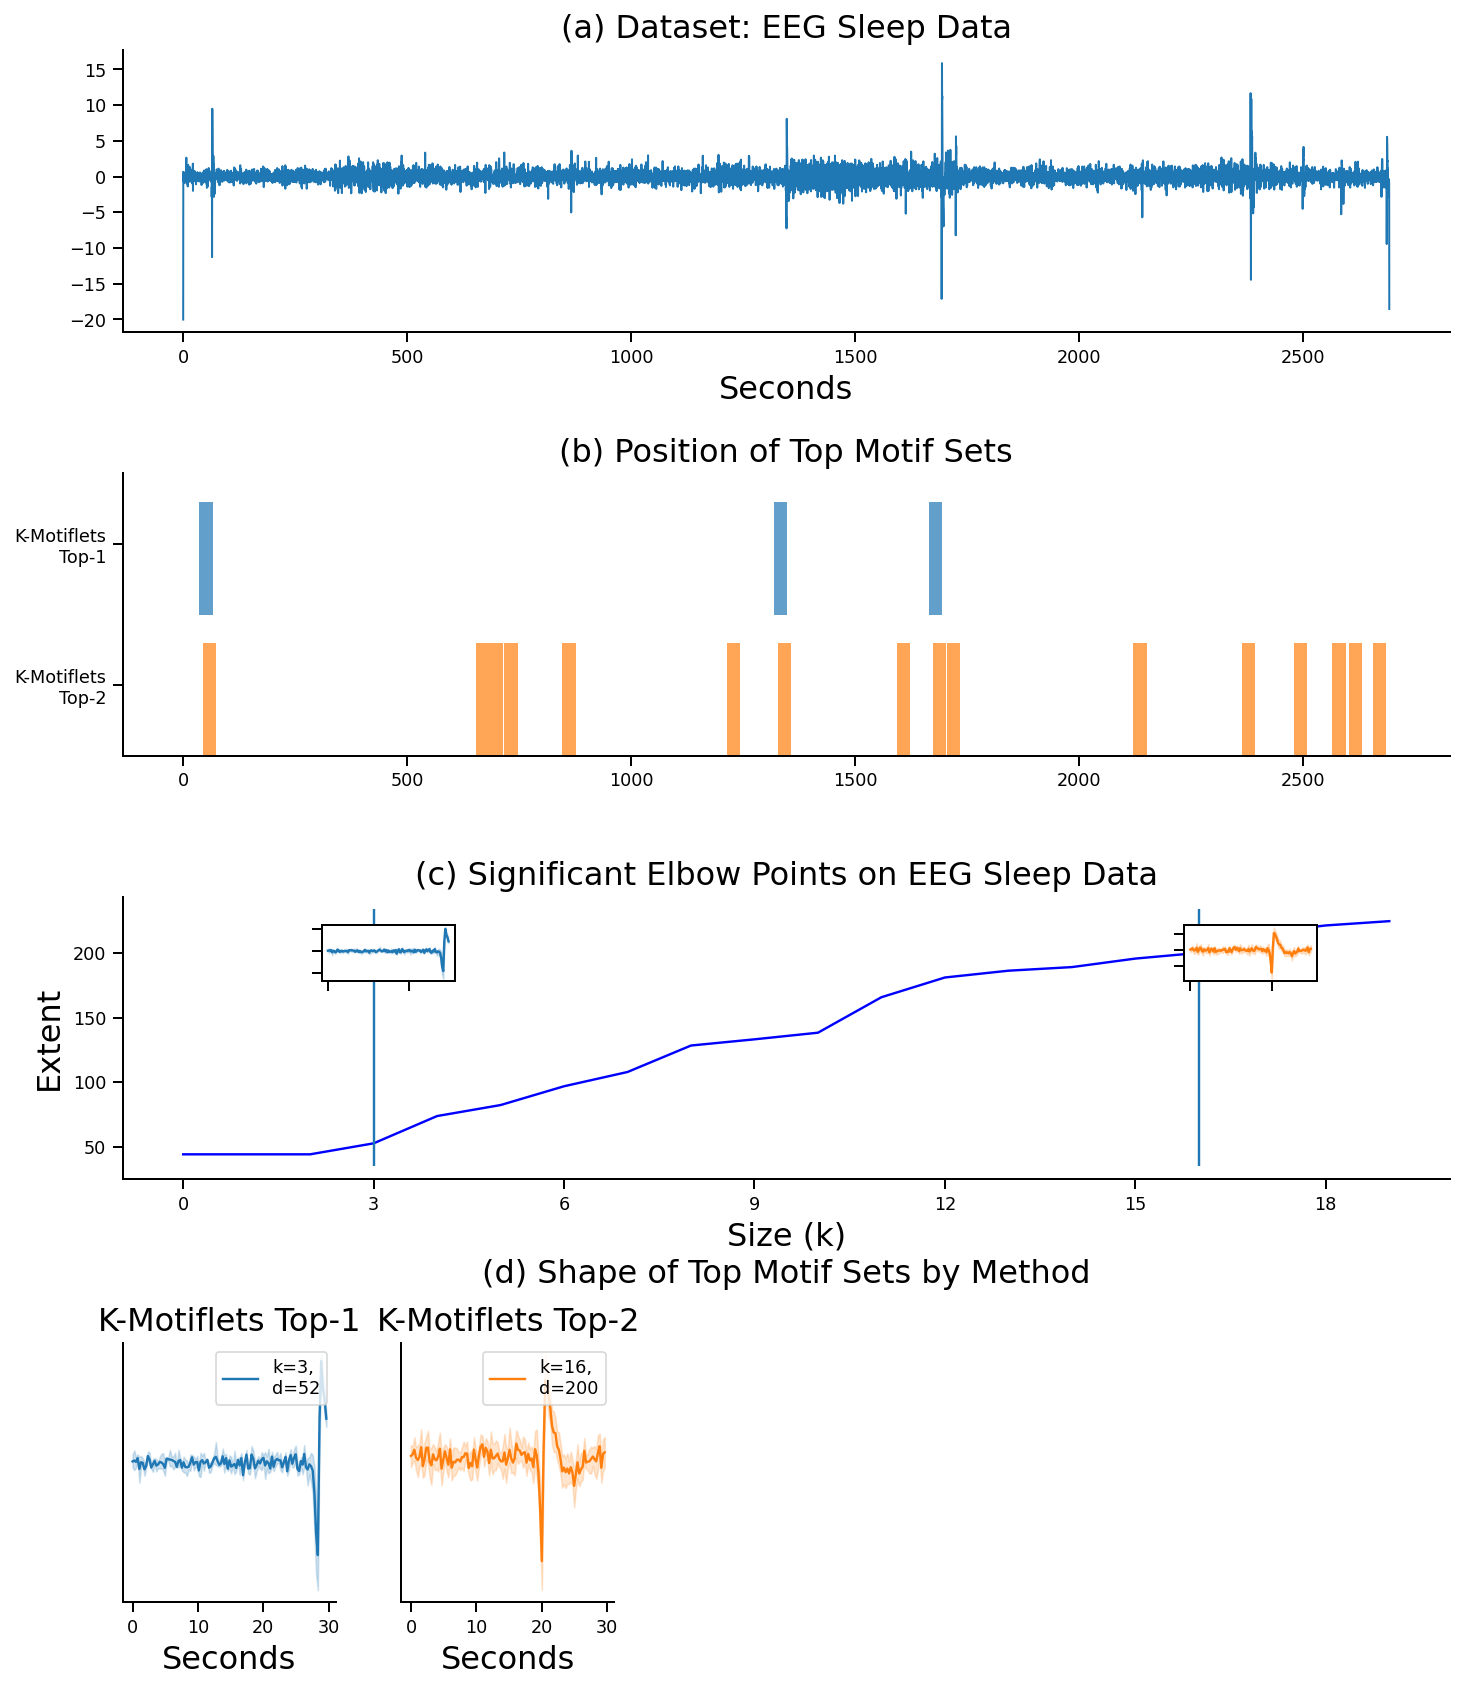

In [8]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True, 
    motif_length=motif_length, method_name="K-Motiflets")

In [12]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df_comp = append_all_motif_sets(df_comp, motiflets, "Motiflets", D_full)
r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])
print("Radius r of TOP-2 Motifs", r_top1, r_top2)
print("Extent d of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius r of TOP-2 Motifs 153.97850036621094 50.98815155029297
Extent d of TOP-1 Motif 200.11978149414062


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error.

We pretend to have an oracle on the length l and the radius r. But this oracle is off by just 11% on both parameters to reflect human trial-and-error.

In [13]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

# Human error due to trial-and-error
error = 0.11

rs = radii * (1.0*(1-error))
mls = np.int32(motif_length * (1+error))

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

print("Radii with human error\t", rs)
print("Length with human error\t", mls)

Radii r [ 50.98815155 153.97850037]
Best Radii	 [ 50.98815155 153.97850037]
Best Lengths	 115
Radii with human error	 [ 45.37945488 137.04086533]
Length with human error	 127


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [15]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/set_finder.jar',
       dataset,
       'SetFinder',
       str(list(rs)),
       str(mls)])

Factor:26 10357
Dataset:/Users/bzcschae/workspace/motiflets/notebooks/../datasets/npo141.csv
Set Finder
[
	[5089, 2743, 3240, 6421, 6543, 8145, 9077, 9522, 9853, 10199],
]


r: 150.18431091308594 d: 217.98695373535156
Filtered Elbow Points [0]


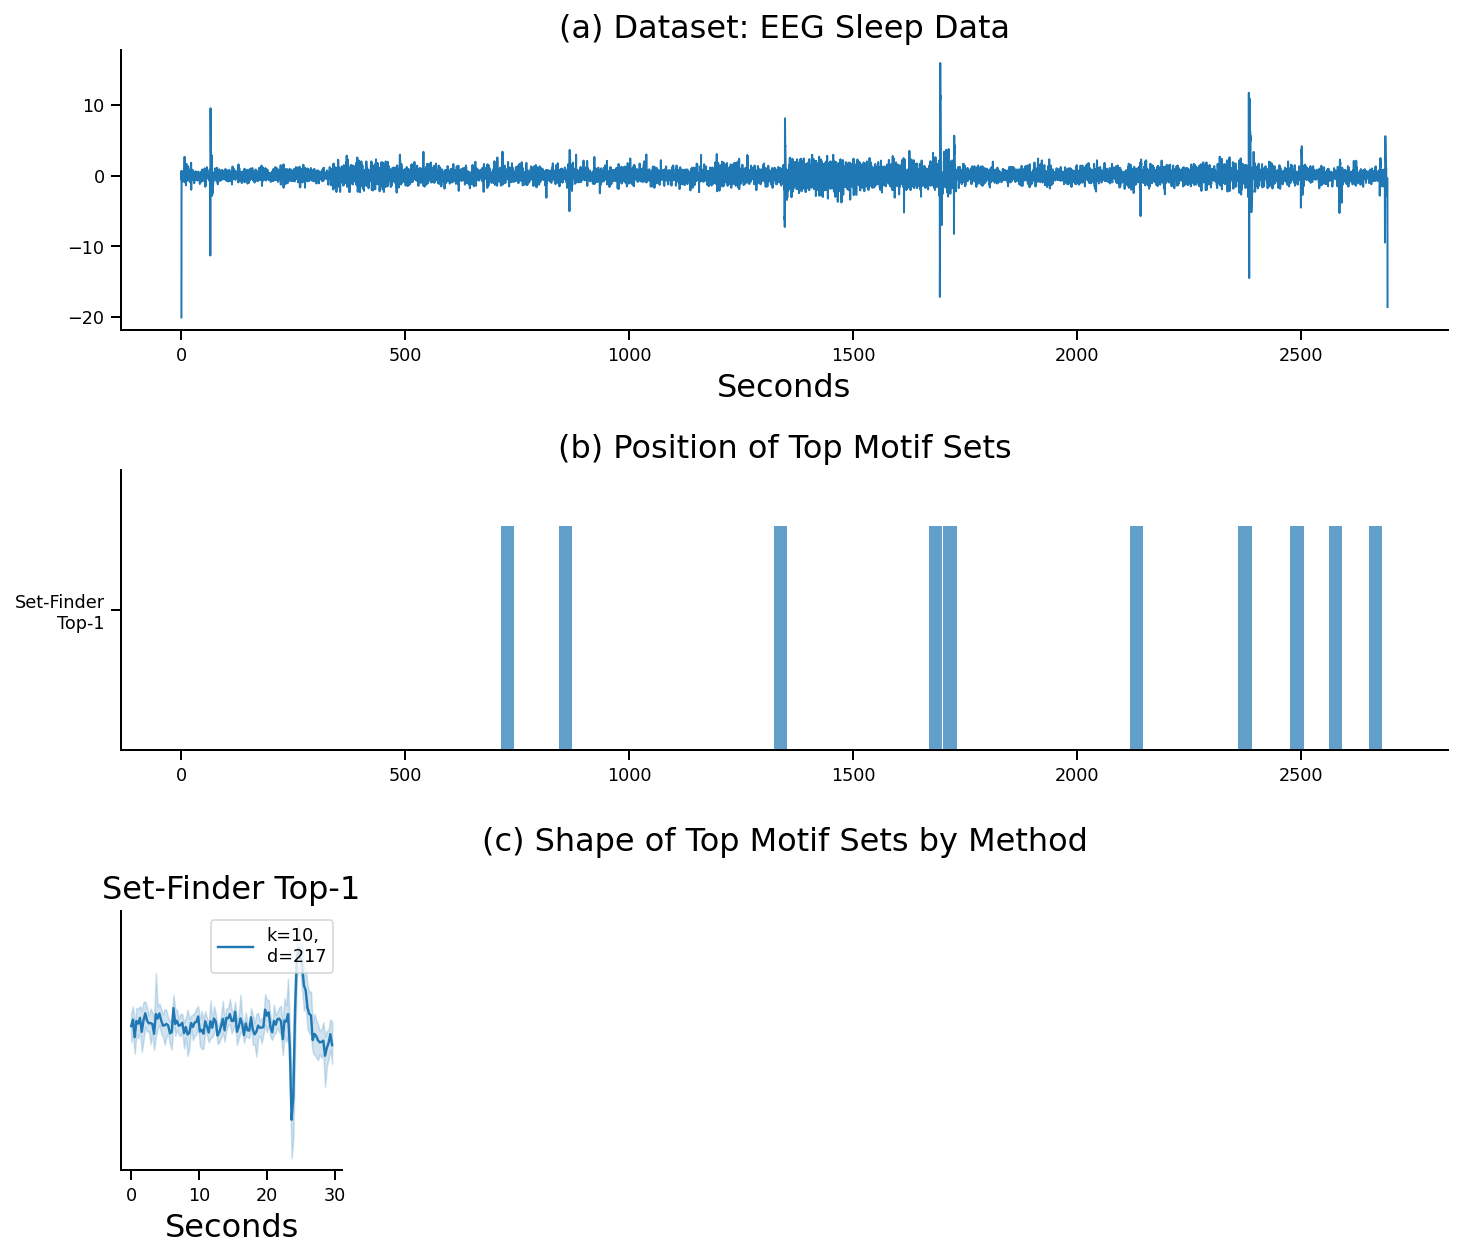

In [16]:
# run jave code first       
ms_set_finder = [
	[5089, 2743, 3240, 6421, 6543, 8145, 9077, 9522, 9853, 10199],
]

motifset = plot_competitors(series, ds_name, ms_set_finder, motif_length, prefix="Set-Finder")

df["Set Finder Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_set_finder, "Set Finder", D_full)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [17]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/emma.jar',
       dataset,
       str(list(rs)),
       str(mls)])

EMMA
Factor:26 10357
[
	[249, 5182, 6635, 9175, 9616],
]


r: 123.01140594482422 d: 149.99734497070312
Filtered Elbow Points [0]


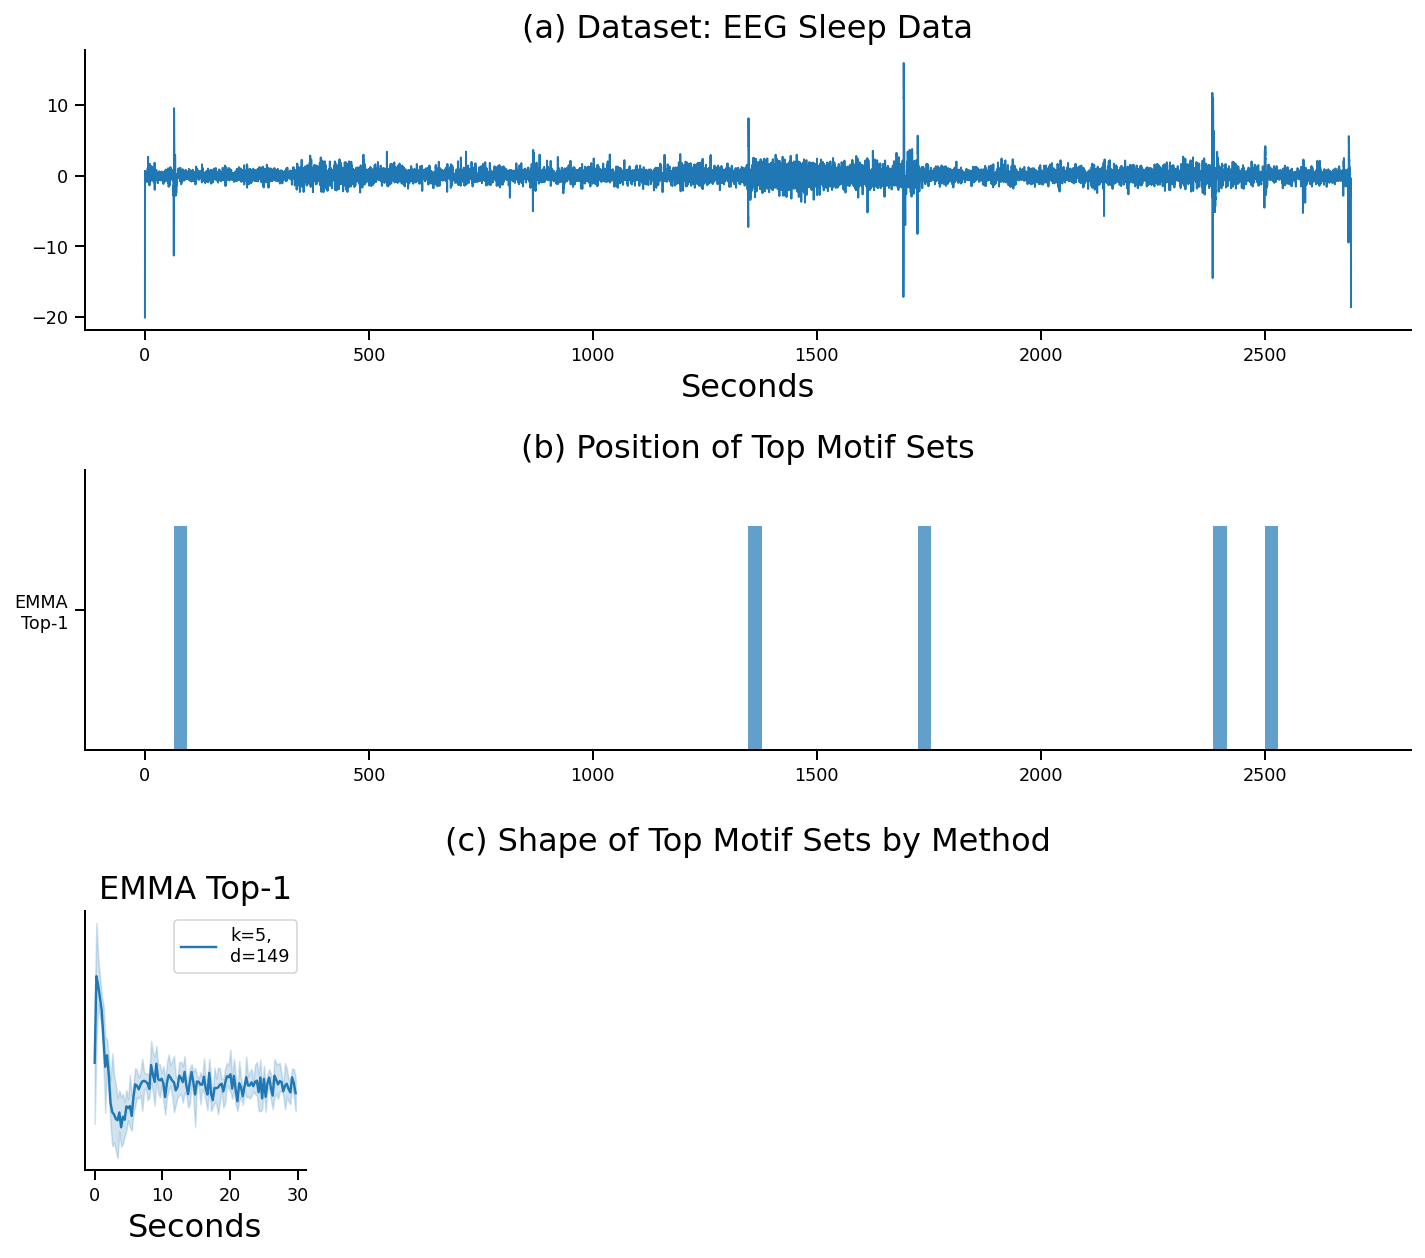

In [18]:
# run jave code first       
ms_emma = [
	[249, 5182, 6635, 9175, 9616],
]

motifset = plot_competitors(series, ds_name, ms_emma, motif_length, prefix="EMMA")

df["EMMA Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_emma, "EMMA", D_full)

# Valmod Motif Sets
based on own (fixed-length) implementation

[array([ 6408, 10230]), array([ 5075,  6408, 10230])]
r: 50.01237487792969 d: 50.01237487792969
r: 50.01237487792969 d: 79.64456939697266
Filtered Elbow Points [1]


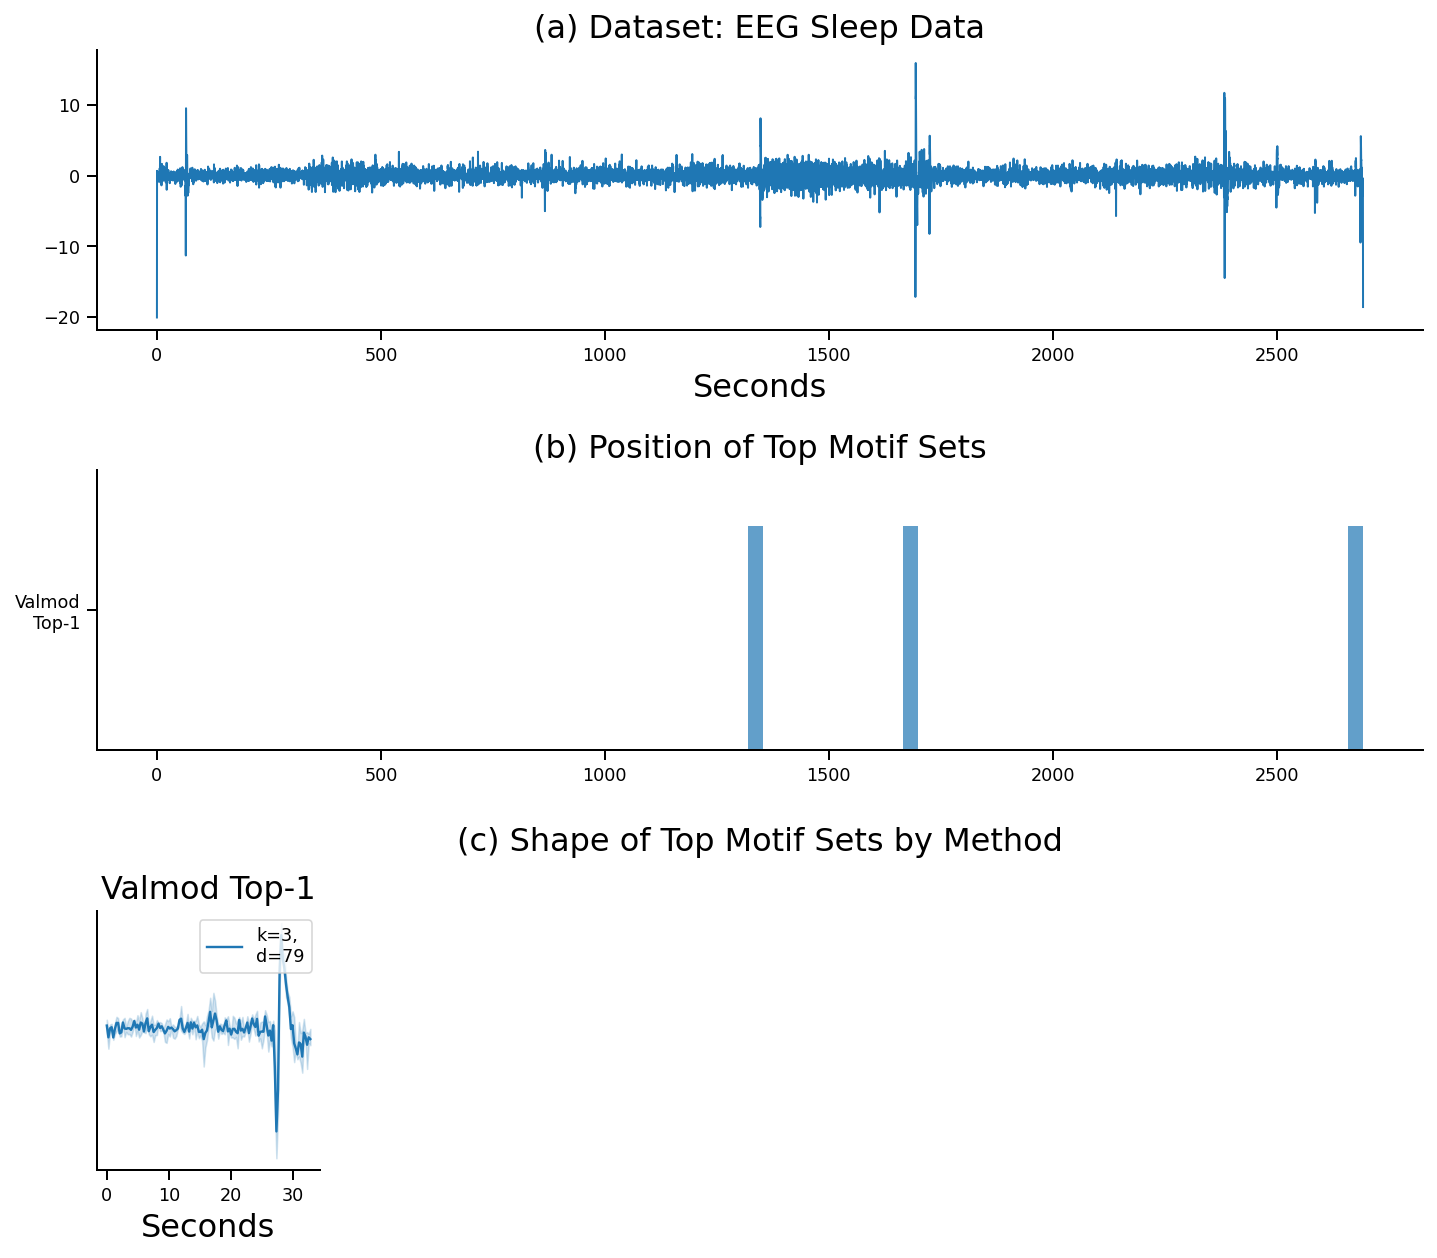

In [20]:
ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs[-1]))
print(ms_valmod)             
motifset = plot_competitors(series, ds_name, ms_valmod, 
                            mls, prefix="Valmod")

df["VALMOD Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_valmod, "VALMOD", D_full)

# Learning Motifs
See Java Code

In [31]:
if rerun_all_jars:
    output = subprocess.call(['java', '-jar', 
       '../jars/latent_motifs.jar',
       dataset,
       str(list(rs)),
       str(mls)])

Learning Motifs
Factor:26 10357
[
	[9616,],
	[361,2480,2998,5318,5391,5482,5616,5704,5924,6034,6113,6297,6456,7801,8281,9115,9367,9444,9557,10028,],
]


r: 250.54617309570312 d: 284.418701171875
Filtered Elbow Points [0]


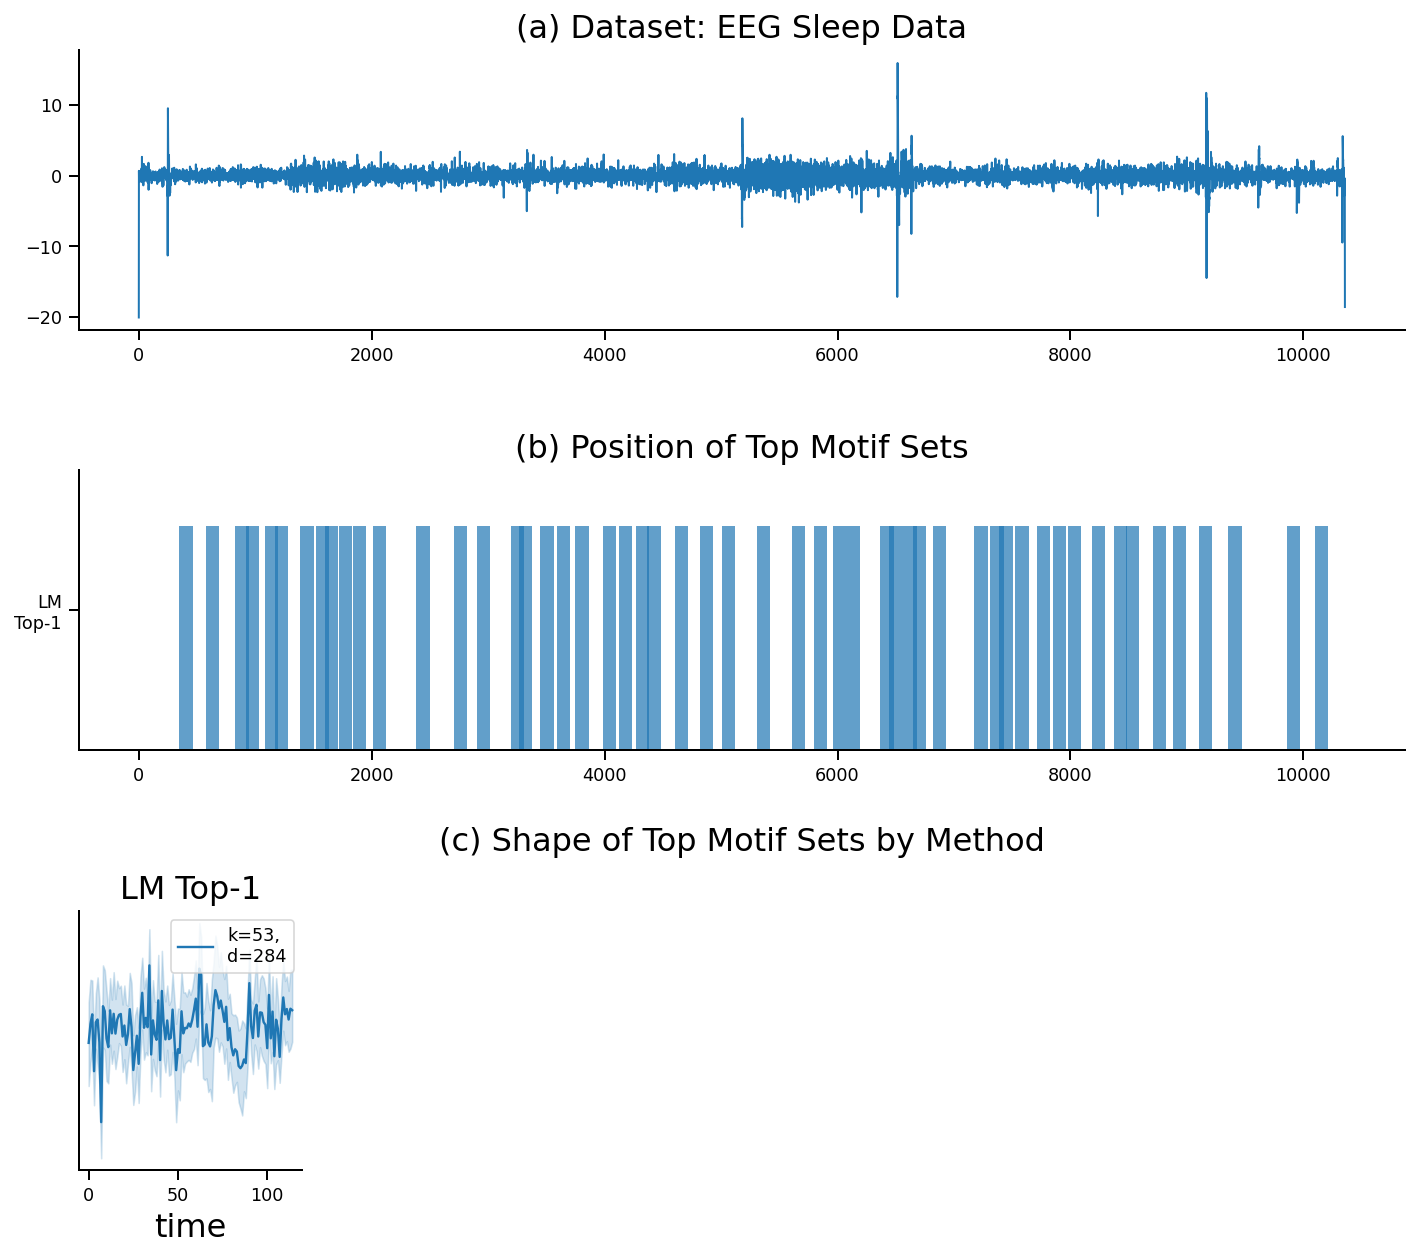

In [32]:
ms_learning_motifs = np.array([
[349,573,828,920,1083,1170,1387,1518,1597,1720,1841,2007,2383,2704,2902,3196,3265,3448,3588,3749,3986,4122,4271,4368,4604,4819,5008,5307,5608,5796,5965,6078,6367,6444,6565,6650,6816,7176,7313,7390,7527,7713,7848,7980,8187,8376,8477,8708,8882,9103,9355,9858,10099,],
])
    
motifset = plot_competitors(data, ds_name, 
                            ms_learning_motifs, motif_length, 
                            prefix="LM")

df["LM Top-1"] = [motifset[-1]]
df_comp = append_all_motif_sets(df_comp, ms_learning_motifs, "LM", D_full)

# Comparison

In [33]:
df_2 = df.T
df_2.rename(columns={0:"offsets"}, inplace=True)
df_2

,offsets
Motiflets Top-1,"[171, 6437, 9092, 5104, 3255, 6557, 9537, 8159..."
Set Finder Top-1,"[5089, 2743, 3240, 6421, 6543, 8145, 9077, 952..."
EMMA Top-1,"[249, 5182, 6635, 9175, 9616]"
VALMOD Top-1,"[5075, 6408, 10230]"
LM Top-1,"[349, 573, 828, 920, 1083, 1170, 1387, 1518, 1..."


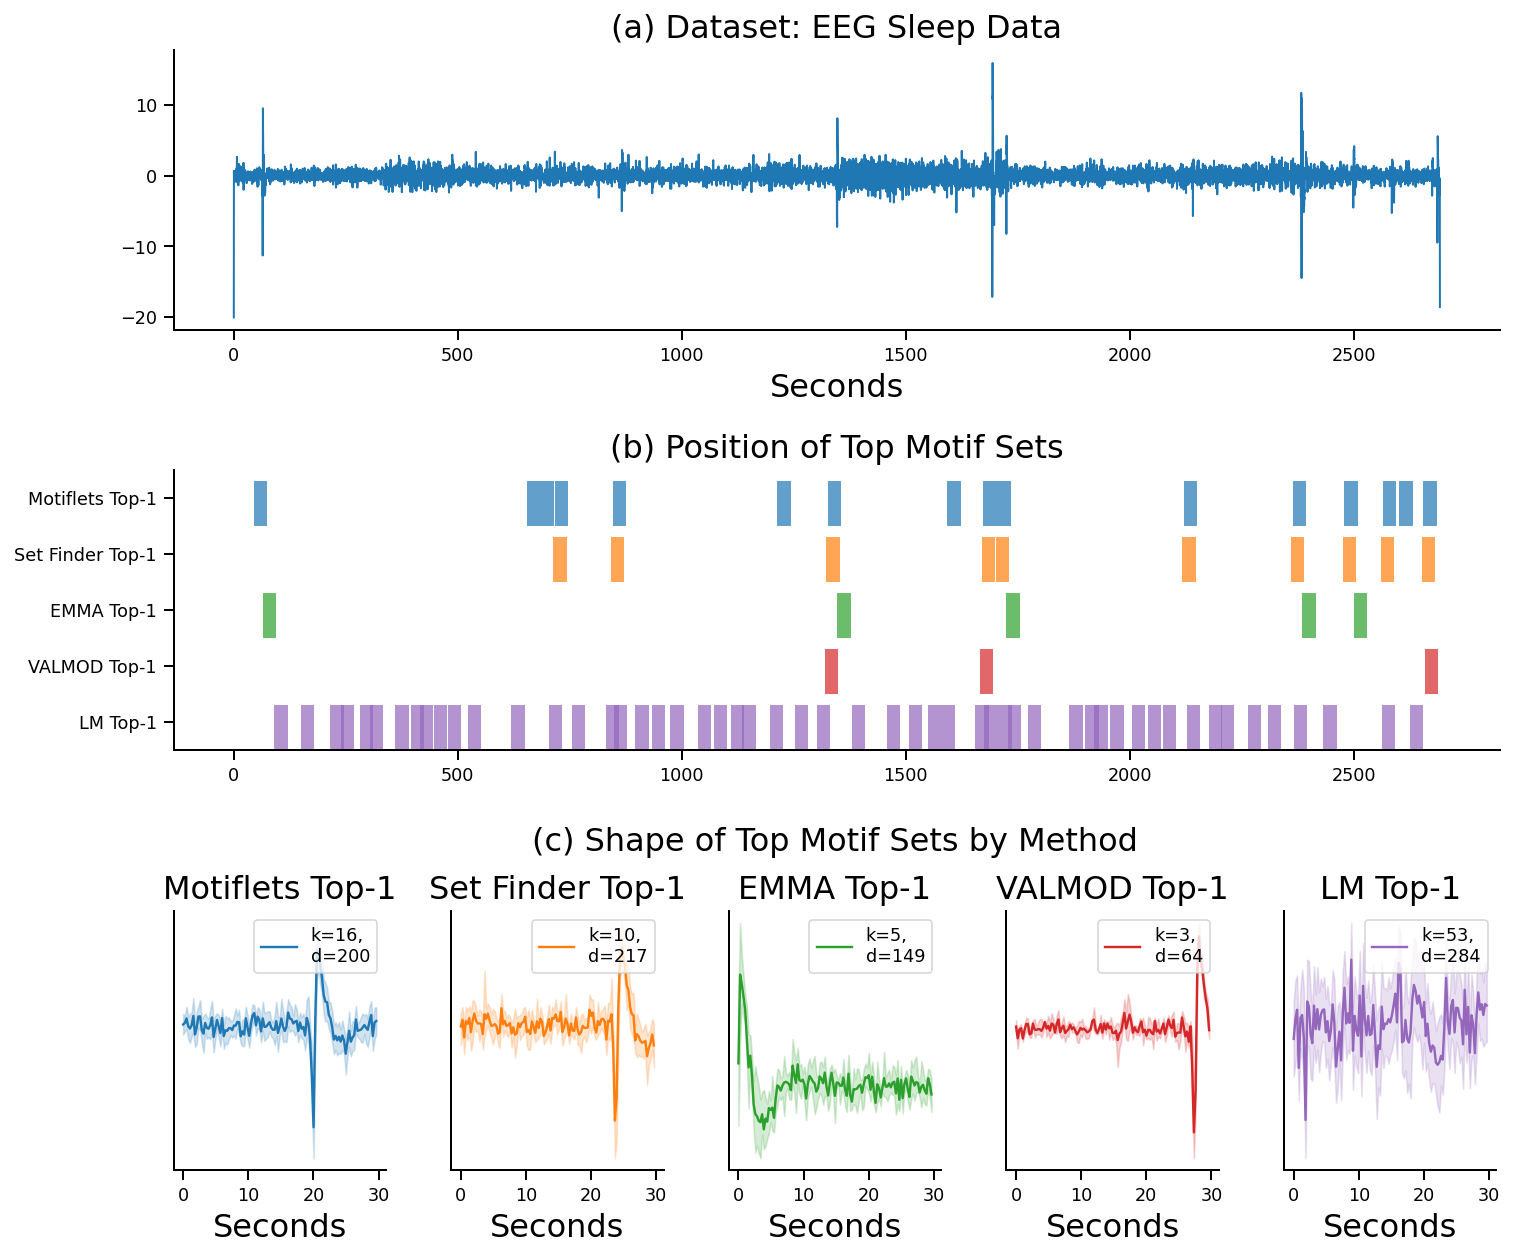

In [34]:
motifsets = np.array(df_2["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_2.index.values)